In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### Pipelining Shenanigans with every single variable

In [4]:
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor, plot_tree 
from sklearn.linear_model import LinearRegression

In [11]:
test_data, train_data = pd.read_csv('fhs_test.csv'), pd.read_csv('fhs_train.csv')

y = 'TenYearCHD'
cat_vars = ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']

In [58]:
def pipe(cat_vars, num_vars):
    X_vars = cat_vars + num_vars
    cat_pipeline = Pipeline(steps = [('ohc', OneHotEncoder(sparse_output=False))])
    num_pipeline = Pipeline(steps = [('maxmin', StandardScaler()), ('imputer', SimpleImputer(strategy='median'))])

    preprocessor = ColumnTransformer(transformers = [('cat', cat_pipeline, cat_vars), ('num', num_pipeline, num_vars)])

    lm_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('linreg', LinearRegression(fit_intercept=False))])
    tree_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('tree', DecisionTreeRegressor(max_depth = 3))])

    X_train = train_data.loc[:, X_vars]
    X_test = test_data.loc[:, X_vars]
    y_train = train_data[y]
    y_test = test_data[y]

    lm = lm_pipe.fit(X_train, train_data[y])
    tree = tree_pipe.fit(X_train, train_data[y])

    # return (lm.score(X_test, test_data[y]), tr.score(X_test, test_data[y]))

    print('Linear Model rsq: ', lm.score(X_test, test_data[y]))  # R-squared
    y_hat_lm = lm.predict(X_test) # Predicted values

    print('Tree rsq: ', tree.score(X_test, test_data[y]) ) # R-squared
    y_hat_tree = tree.predict(X_test) 

    lm = lm_pipe.fit(X_train, y_train)
    tree = tree_pipe.fit(X_train, y_train)

    N_test = len(y_test)
    TSS = np.sum( (y_test - y_train.mean())**2 )

    print('Linear Model rsq: ', lm.score(X_test, y_test) ) # R-squared
    y_hat_lm = lm.predict(X_test) # Predicted values
    SSE_lm = np.sum( (y_test-y_hat_lm)**2 )
    MSE_lm = (1/N_test)*np.sum( (y_test-y_hat_lm)**2 )
    RMSE_lm = (SSE_lm/N_test)**(1/2)
    R2_lm = 1 - SSE_lm/TSS

    print('Slope Coefficients: ', lm_pipe.named_steps['linreg'].coef_) # Regression coefficients
    print('Intercept: ', lm_pipe.named_steps['linreg'].intercept_) # Regression coefficients

    plt.scatter(x=y_hat_lm,y=y_test)
    plt.title('Linear Model: Predicted vs. Actual Values')
    plt.show()

    sns.kdeplot(x=y_test - y_hat_lm).set_title('Linear Model: Residuals')
    plt.show()

    print('Tree rsq: ', tree.score(X_test, y_test) ) # R-squared
    y_hat_tree = tree.predict(X_test) 
    SSE_tree = np.sum( (y_test-y_hat_tree)**2 )
    MSE_tree = (1/N_test)*np.sum( (y_test-y_hat_tree)**2 )
    RMSE_tree = (SSE_tree/N_test)**(1/2)
    R2_tree = 1 - SSE_tree/TSS

    plot_tree(tree_pipe.named_steps['tree'],filled=True)
    plt.show()

    plt.scatter(x=y_hat_tree,y=y_test)
    plt.title('Tree: Predicted vs. Actual Values')
    plt.show()

    sns.kdeplot(x=y_test - y_hat_tree).set_title('Tree: Residuals')
    plt.show()


Linear Model rsq:  0.08692098982383112
Tree rsq:  0.024293246823977155
Linear Model rsq:  0.08692098982383112
Slope Coefficients:  [-4.00515030e+11 -4.00515030e+11 -3.19231366e+11 -3.19231366e+11
 -3.19231366e+11 -3.19231366e+11 -3.19231366e+11 -1.09746167e+12
 -1.09746167e+12  3.80398525e+12  3.80398525e+12  3.80398525e+12
  2.92352062e+12  2.92352062e+12 -1.50171897e+12 -1.50171897e+12
 -3.40857883e+12 -3.40857883e+12  5.68197001e-02  3.36035677e-02
  1.21155430e-02  4.95750122e-02 -1.58661570e-02 -2.71542881e-03
  9.00011556e-04  2.75687815e-02]
Intercept:  0.0


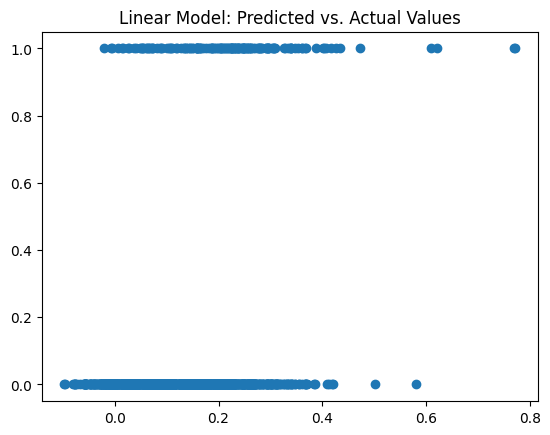

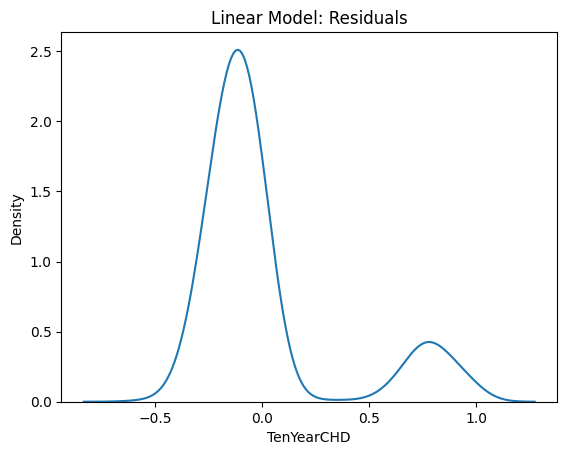

Tree rsq:  0.024293246823977155


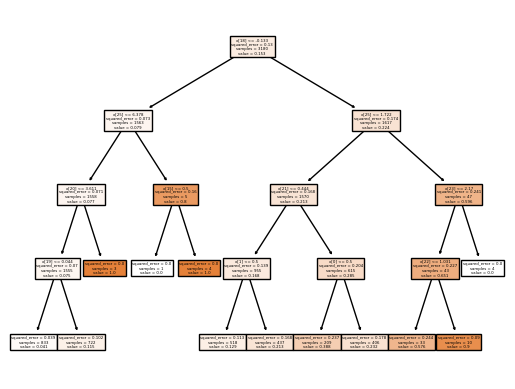

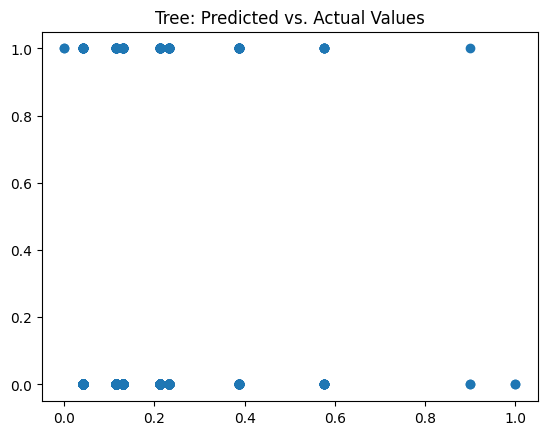

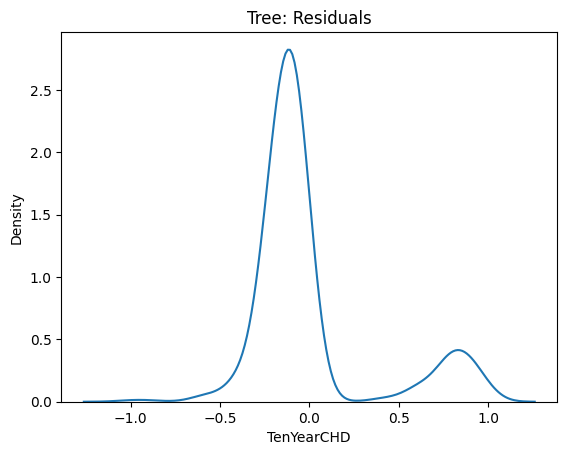

In [59]:
cat_vars = ['sex', 'education', 'currentSmoker', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
num_vars = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
pipe(cat_vars, num_vars)


In [40]:
pipe([], ['cigsPerDay'])

(-0.1673698545377429, -0.006338712530999713)

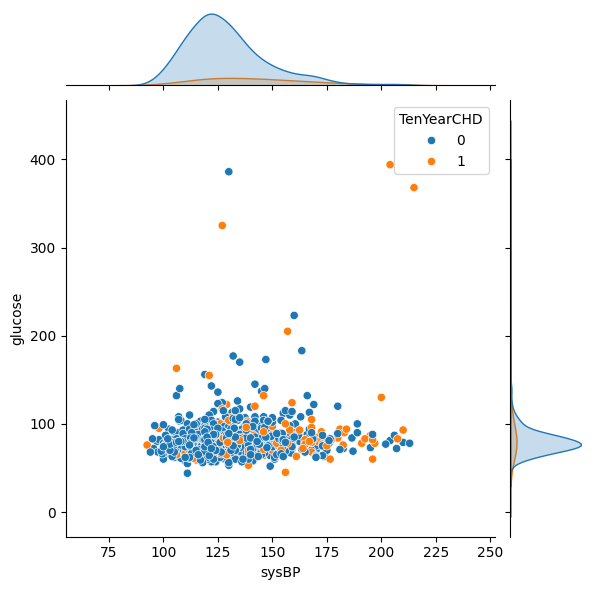

In [37]:
sns.jointplot(data=test_data, y='glucose', x='sysBP', hue='TenYearCHD')